In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from math import pi
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['figure.facecolor'] = 'white'
np.warnings.filterwarnings('ignore')


Xdict = {}
Pdict = {}

In [2]:
cmap = plt.get_cmap('jet')
half_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=0.5, b=1.0),
        cmap(np.linspace(0.5, 1.0, 100)))


In [3]:
'''
k-space representation of infinitely thin pressure source 
of finite length (1 / 2 F). So ranges from [-1/F, 1/F]
'''
def phi_finite(kx, ky, F2, l):
    k = np.sqrt(kx * kx + ky * ky)
    pressure = 2. * F2 * np.sin(kx / (2 * F2)) / kx
    pressure[kx == 0] = 1
    return k * pressure / ((kx + l*1.0j) * (kx + l*1.0j) - k)

def calculate_wake(F, l=0.01, kmax=128, d=0.125):
    k = np.arange(-kmax, kmax+d, d)
    n = len(k)
    
    m = (n - 1) / 2
    x = pi / (d * m) * np.arange(-m, m+1, 1)
    
    phi_induced = phi_finite(k[:, None], k[None, :], \
                             np.power(F, 2.0), l)
    
    #Rotate grid since dft starts at zero
    phi_grid = np.roll(phi_induced, -m, axis=0)
    phi_grid = np.roll(phi_grid, -m, axis=1)
    
    fPhi = d*d * np.fft.ifft2(phi_grid)
    fPhi = np.roll(fPhi, m, axis=1)
    fPhi = np.roll(fPhi, m, axis=0)
    fPhi = np.transpose(fPhi)
    
    return x, fPhi

In [4]:
phase = -1.7

def calc_T_value(kmax):
    '''
    Calculate the cutoff T value given a cutoff kmax value
    Note that the kmax cutoff value creates a square in k-space
    with side length 2*kmax
    '''
    km2 = kmax * kmax
    if km2 < 2:
        return km2
    return (1. + np.sqrt(1 + 4 * km2)) / 2.

def draw_wake_wedge(ax, x, ph, wedge, magnitude=False, bound=None):
    r = x[-1]
    phi = np.copy(ph)
    
    
    #phi[~wedge] = 0
    
    avg = np.average(phi)
    stdev = np.std(phi)
    
    if bound is not None:
        ubound = avg + bound * stdev
        lbound = avg - bound * stdev
        phi = phi * (phi < ubound) * (phi > lbound)
        phi[phi > ubound] = ubound
        phi[phi < lbound] = lbound
    
    ubound = np.max(phi[:])
    lbound = np.min(phi[:])
    rnge = ubound - lbound
    phi = phi - lbound - rnge/2
    phi = phi / rnge * 2
        
    phi[~wedge] = 0
    ubound = np.max(phi[:])
    lbound = np.min(phi[:])
    rnge = ubound - lbound
    phi = phi - lbound - rnge/2
    phi = phi / rnge * 2
    
    if magnitude:
        img = plt.imshow(np.abs(phi), extent=[-r, r, -r, r], \
                         interpolation='gaussian', cmap='Greys')
    else:
        img = plt.imshow(phi, extent=[-r, r, -r, r], \
                         interpolation='gaussian')
    return img
    
    
def draw_wake_plot(ax, x, phi, bound=None, scale=False, magnitude=False):
    r = x[-1]
        
    stdev = np.std(phi)
    if bound is not None:
        avg = np.average(phi)
        ubound = avg + bound * stdev
        lbound = avg - bound * stdev
        toshow = phi * (phi < ubound) * (phi > lbound)
        toshow[phi > ubound] = ubound
        toshow[phi < lbound] = lbound
    else:
        toshow = phi
        avg = np.average(phi)
        ubound = np.max(toshow[:])
        lbound = np.min(toshow[:])
    if scale:
        toshow -= avg
        toshow = toshow / (ubound - lbound) * 2
        if magnitude:
            img = plt.imshow(np.abs(toshow), extent=[-r, r, -r, r], \
                             interpolation='gaussian', cmap='Greys',
                             vmin=0, vmax=1)
        else:
            img = plt.imshow(toshow, extent=[-r, r, -r, r], \
                             interpolation='gaussian',
                             vmin=-1, vmax=1)
    else:
        ubound = np.max(toshow[:])
        lbound = np.min(toshow[:])
        rnge = ubound - lbound
        toshow = toshow - lbound - rnge/2
        toshow = toshow / rnge * 2
        if magnitude:
            img = plt.imshow(np.abs(toshow), extent=[-r, r, -r, r], \
                             interpolation='gaussian', cmap='Greys')
        else:
            img = plt.imshow(toshow, extent=[-r, r, -r, r], \
                             interpolation='gaussian')
    return img

def draw_kelvin_angle_long(ax, x, F, color='blue'):
    slope = -1. / np.sqrt(8)
    y = slope * (x + 0.5 / (F * F))
    ax.plot(x, y, color=color, linestyle=':', linewidth=2)

def draw_kelvin_angle(ax, x, color='blue'):
    slope = -1. / np.sqrt(8)
    y = np.zeros(x.shape)
    y[0, :] = slope * (x[0, :] - x[0, 1])
    y[1, :] = slope * (x[1, :] - x[1, 1])
    ax.plot(x[0, :], y[0, :], color=color, linestyle=':')
    ax.plot(x[1, :], y[1, :], color=color, linestyle=':')
    
def draw_parametric_wake(ax, nmax, t, x=[0], color='black', phase=phase):
    t32 = np.power(t, 1.5)
    xtterm = (2*t - 1) / t32
    ytterm = np.sqrt(t - 1) / t32
    for n in range(1, nmax+1):
        t32 = np.power(t, 1.5)
        xt = -np.pi * (2 * n + 1 + phase) * xtterm
        yt = -np.pi * (2 * n + 1 + phase) * ytterm
        for xz in x:
            ax.plot(xt+xz, -yt, color=color, linestyle=':')

def fplus(x, y):
    x2 = np.power(x, 2.0)
    y2x2 = np.power(y, 2.0) / x2
    num = -x2 * np.power(1. + 4. * y2x2 + np.sqrt(1. - 8. * y2x2), 1.5)
    den = 4. * np.sqrt(2.) * y * (1. + np.sqrt(1. - 8. * y2x2))
    return num / den

def fminus(x, y):
    x2 = np.power(x, 2.0)
    y2x2 = np.power(y, 2.0) / x2
    num = -x2 * np.power(1. + 4. * y2x2 - np.sqrt(1. - 8. * y2x2), 1.5)
    den = 4. * np.sqrt(2.) * y * (1. - np.sqrt(1. - 8. * y2x2))
    return num / den

def phase_contour(ax, x, y, a, rng, extent, linestyles=':'):  
    fo = (2 * rng + 1) * np.pi
    fe = (2 * rng) * np.pi
    ax.contour(x, y, fplus(x + a/2., y) - fplus(x - a/2., y), fo, 
               colors='red', linestyles=linestyles, extent=extent, linewidths=1.5)
    #ax.contour(x, y, fplus(x + a/2., y) - fminus(x - a/2., y), fo, 
    #           colors='yellow', linestyles=linestyles, extent=extent, linewidths=2)
    #ax.contour(x, y, fminus(x + a/2., y) - fplus(x - a/2., y), fo, 
    #           colors='yellow', linestyles=linestyles, extent=extent, linewidths=2)
    ax.contour(x, y, fminus(x + a/2., y) - fminus(x - a/2., y), fo, 
               colors='red', linestyles=linestyles, extent=extent, linewidths=1.5)
    #ax.contour(x, y, fplus(x + a/2., y) - fplus(x - a/2., y), fe, 
    #           colors='red', linestyles=linestyles, extent=extent, linewidths=2)
    #ax.contour(x, y, fplus(x + a/2., y) - fminus(x - a/2., y), fe, 
    #           colors='purple', linestyles=linestyles, extent=extent, linewidths=2)
    #ax.contour(x, y, fminus(x + a/2., y) - fplus(x - a/2., y), fe, 
    #           colors='purple', linestyles=linestyles, extent=extent, linewidths=2)
    #ax.contour(x, y, fminus(x + a/2., y) - fminus(x - a/2., y), fe, 
    #           colors='red', linestyles=linestyles, extent=extent, linewidths=2)

def phase_contour_diff_color(ax, x, y, a, f, rng, extent, colors=['orange', 'red'], kmax=None):
    fo = (2 * rng + 1) * np.pi
    kns = np.power(fo, 2) * np.power(f, 4)
    print(kns)
    if kmax is not None:
        fo = fo[kns < kmax]
        kns = kns[kns < kmax]
    mask = kns < 1.5

    ax.contour(x, y, fplus(x + a/2., y) - fplus(x - a/2., y), fo[mask],
               colors=colors[0], linestyles=':', extent=extent, linewidths=1.5)
    ax.contour(x, y, fminus(x + a/2., y) - fminus(x - a/2., y), fo[mask],
               colors=colors[0], linestyles=':', extent=extent, linewidths=1.5)
    ax.contour(x, y, fplus(x + a/2., y) - fplus(x - a/2., y), fo[~mask],
                colors=colors[1], linestyles=':', extent=extent, linewidths=1.5)
    ax.contour(x, y, fminus(x + a/2., y) - fminus(x - a/2., y), fo[~mask],
               colors=colors[1], linestyles=':', extent=extent, linewidths=1.5)
    

In [5]:
def create_large_figure(fig, xdict, pdict, froudes, 
                        bounds=None, scale=False, contour=False,
                        xbounds=None, ybounds=None):
    nfroudes = len(froudes)
    
    fo = (2 * phase + 1) * np.pi
    
    for r in range(nfroudes):
        bound = bounds
        fr = froudes[r]
        a = 1. / (fr * fr)
        #xs = xdict[fr][xdict[fr] < -0.5 * a]
        #ys = xdict[fr][xdict[fr] > 0]
        xm = np.linspace(xbounds[0], -0.5 * a, num=250)
        ym = np.linspace(0.0, ybounds[1], num=250)
        x, y = np.meshgrid(xm, ym)
        
        for c, mag in enumerate([False, True]):
            i = r * 2 + c
            ax = fig.add_subplot(nfroudes, 2, i+1)

            img = draw_wake_plot(ax, xdict[fr], pdict[fr], bound=bound, scale=scale, magnitude=mag)

            plt.plot(np.array([-0.5 * a, 0.5 * a]), np.zeros(2), color='black', linewidth=2)
  
            if contour:
                phase_contour_diff_color(ax, x, y, 1./(fr * fr), fr, phase, extent=[xm[0], xm[-1], ym[0], ym[-1]])
                #phase_contour(ax, x, y, 1./(fr*fr), phase, extent=[xm[0], xm[-1], ym[0], ym[-1]])
            
            #draw_kelvin_angle_long(ax, xm, fr)

            if xbounds is not None:
                ax.set_xlim(xbounds)
            if ybounds is not None:
                ax.set_ylim(ybounds)
            ax.text(0.97, 0.97, 'F=%.3f' % fr, 
                    transform=ax.transAxes,
                    horizontalalignment='right',
                    verticalalignment='top')

            if c == 0:
                ax.set_ylabel('Y')
            else:
                nlbls = len(ax.get_yticklabels())
                ax.set_yticklabels([''] * nlbls)
            if r == nfroudes - 1:
                ax.set_xlabel('X')
            else:
                nlbls = len(ax.get_xticklabels())
                ax.set_xticklabels([''] * nlbls)

In [6]:
bigFs = [1.7, 1.5, 1.3, 1.0956]

lrgFs = [1.0, 0.9, 0.8, 0.75]

smlFs = [0.580, 0.564190, 0.500, 0.398943]

lowFs = [0.36, 0.326, 0.3, 0.282, 0.27, 0.252, 0.24, 0.230, 0.22, 0.2135, 0.205, 0.199]

kmax = 64 #For testing
kmax = 128 #For final images
delta = 1. / 8.
delta = 1. / 16.

ttFs = [0.580, 0.566, 0.5642, 0.563, 0.560, 0.500, 0.450, 0.420, 0.399, 0.380, 0.360, 0.340, 0.330, 0.32574, 0.320]

tt1Fs = [0.420, 0.415, 0.410, 0.405, 0.399]
tt2Fs = [0.340, 0.337, 0.334, 0.330, 0.32574]


#kmax = 1.5
#delta = 1./64.

def generate_wake_patterns(xdict, pdict, fvals, kmax, delta):
    for f in fvals:
        x, p = calculate_wake(f, kmax=kmax, d=delta)
        xdict[f] = np.real(x)
        pdict[f] = np.real(p)
        print('F = %f done' % f)

In [7]:
generate_wake_patterns(Xdict, Pdict, bigFs, kmax, delta)
generate_wake_patterns(Xdict, Pdict, lrgFs, kmax, delta)
generate_wake_patterns(Xdict, Pdict, smlFs, kmax, delta)

F = 1.700000 done
F = 1.500000 done
F = 1.300000 done
F = 1.095600 done
F = 1.000000 done
F = 0.900000 done
F = 0.800000 done
F = 0.750000 done
F = 0.580000 done
F = 0.564190 done
F = 0.500000 done
F = 0.398943 done


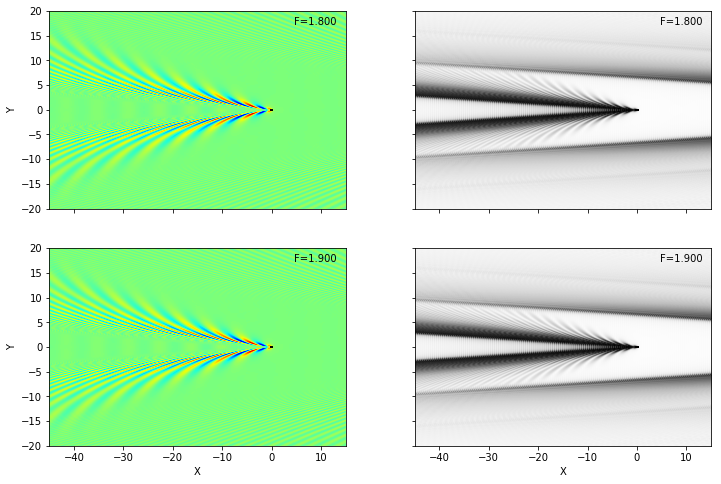

In [18]:
phase = np.arange(0, 1)
phase = np.array([])
toplot = bigFs[7:]
fig = plt.figure(figsize=(12, 4 * len(toplot)))
create_large_figure(fig, Xdict, Pdict, toplot,
                    scale=False, bounds=3, contour=True,
                    xbounds=[-45, 15], ybounds=[-20, 20])

a
[   82.43192292   741.88730627  2060.79807296  4039.164223
  6676.98575639  9974.26267312 13930.9949732  18547.18265663]
b
[   49.96487228   449.68385052  1249.12180701  2448.27874175
  4047.15465472  6045.74954594  8444.06341541 11242.09626312]
c
[  28.18857713  253.69719417  704.71442825 1381.24027937 2283.27474753
 3410.81783272 4763.86953496 6342.42985424]
d
[  14.22026991  127.98242921  355.50674779  696.79322567 1151.84186285
 1720.65265931 2403.22561507 3199.56073013]
a'
[   82.43192292   741.88730627  2060.79807296  4039.164223
  6676.98575639  9974.26267312 13930.9949732  18547.18265663]
b'
[   49.96487228   449.68385052  1249.12180701  2448.27874175
  4047.15465472  6045.74954594  8444.06341541 11242.09626312]
c'
[  28.18857713  253.69719417  704.71442825 1381.24027937 2283.27474753
 3410.81783272 4763.86953496 6342.42985424]
d'
[  14.22026991  127.98242921  355.50674779  696.79322567 1151.84186285
 1720.65265931 2403.22561507 3199.56073013]
e
[   9.8696044    88.82643961  

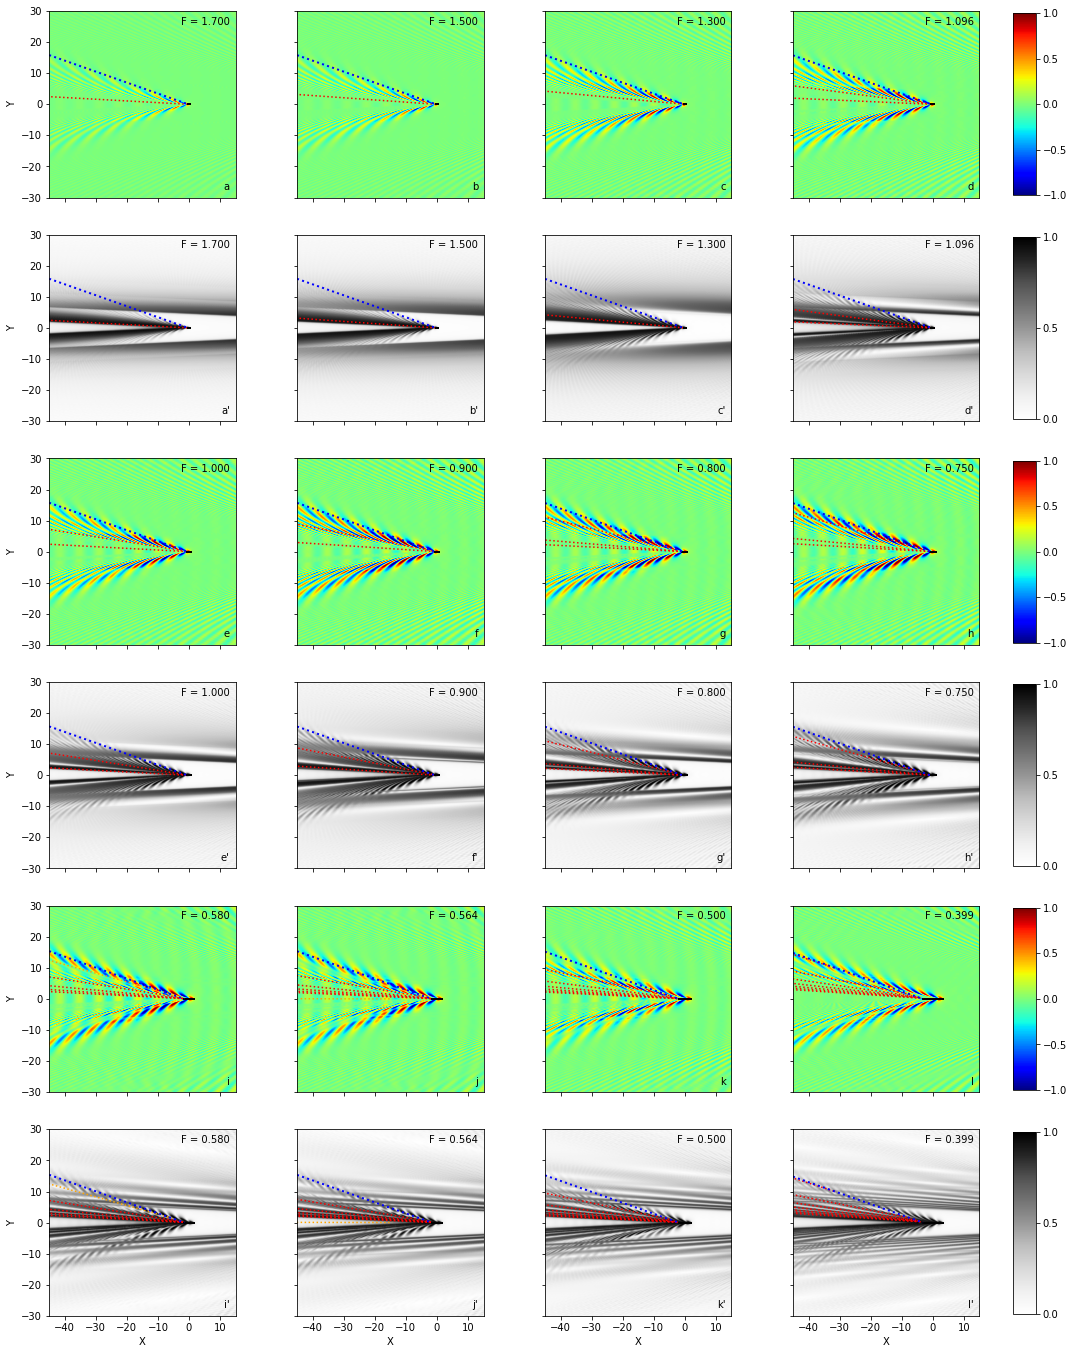

In [8]:
rows = np.array([bigFs, bigFs, lrgFs, lrgFs, smlFs, smlFs])
xbounds = [-45, 15]
ybounds = [-30, 30]
bound = 2
scale = True
phase = np.arange(0, 8)

npy, npx = rows.shape

fig = plt.figure(figsize=(16, 4 * npy))
axs, imgs = [None] * npy, [None] * npy
label = 'a'

for j in range(npy):
    for i in range(npx):
        ind = i + j * npx + 1
        fr = rows[j, i]

        ax1 = fig.add_subplot(npy, npx, ind)
        ax1.set_xlim(xbounds)
        ax1.set_ylim(ybounds)
        ax1.text(0.97, 0.97, r'F = %.3f' % fr, transform=ax1.transAxes, 
                    horizontalalignment='right', 
                    verticalalignment='top')
        lbl = label
        mag = False
        if j % 2 == 1:
            lbl = chr(ord(label) - (npx-i)) + '\''
            mag = True
        print(lbl)
        ax1.text(0.97, 0.03, lbl, transform=ax1.transAxes,
                    horizontalalignment='right',
                    verticalalignment='bottom')

        #Plot main image
        img1 = draw_wake_plot(ax1, Xdict[fr], Pdict[fr], 
                              scale=scale, bound=bound, magnitude=mag)

        ax1.set_xlim(xbounds)
        ax1.set_ylim(ybounds)
        
        a = 1. / (fr * fr)
        xm = Xdict[fr][Xdict[fr] < -0.5 * a]
        ym = Xdict[fr][Xdict[fr] > 0]
        x, y = np.meshgrid(xm, ym)
        
        plt.plot(np.array([-0.5 * a, 0.5 * a]), np.zeros(2), color='black', linewidth=2)
        draw_kelvin_angle_long(ax1, xm, fr)    
        phase_contour_diff_color(ax1, x, y, a, fr, phase, extent=[xm[0], xm[-1], ym[0], ym[-1]], kmax=kmax)
        
        if j == npy-1:
            ax1.set_xlabel('X')
        else:
            nlbls = len(ax1.get_xticklabels())
            ax1.set_xticklabels([''] * nlbls)
        if i == 0:
            ax1.set_ylabel('Y')
        else:
            #Clear tick labels
            nlbls = len(ax1.get_yticklabels())
            ax1.set_yticklabels([''] * nlbls)
        
        axs[j] = ax1
        imgs[j] = img1
        if j %2 == 0:
            label = chr(ord(label) + 1)

#Add colorbars
fig.subplots_adjust(right=0.95)
ticksmag = [0, 0.5, 1]
ticksreg = [-1, -0.5, 0, 0.5, 1]
for j in range(npy):
    bb = axs[j].get_position().bounds
    cbar_ax = fig.add_axes([0.97, bb[1]+0.00125, 0.02, bb[3]-0.0025])
    fig.colorbar(imgs[j], cax=cbar_ax, 
                 ticks=ticksreg if j % 2 == 0 else ticksmag)

plt.show()

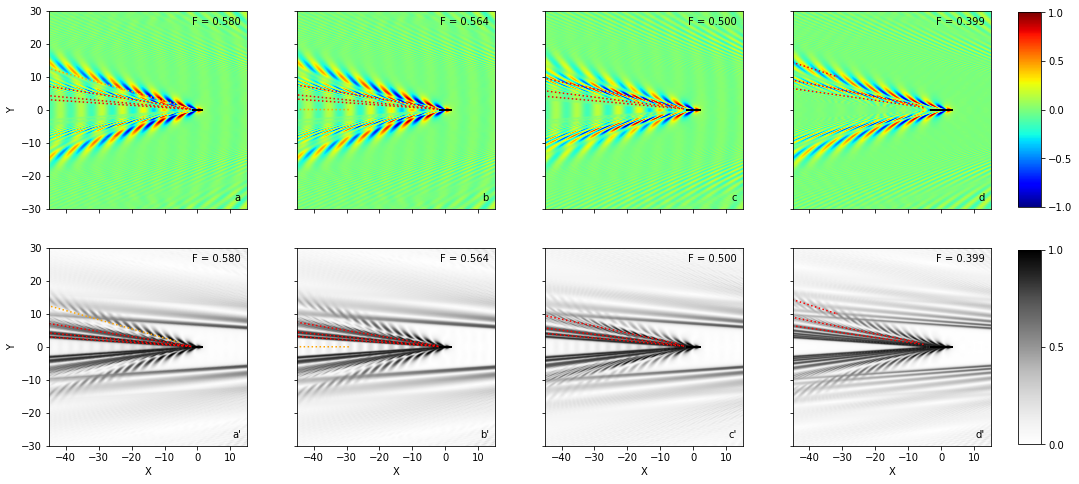

In [12]:
rows = np.array([smlFs, smlFs])
xbounds = [-45, 15]
ybounds = [-30, 30]
bound = 3
scale = True
phase = np.array([0, 1, 2, 3])

npy, npx = rows.shape

fig = plt.figure(figsize=(16, 4 * npy))
axs, imgs = [None] * npy, [None] * npy
label = 'a'

for j in range(npy):
    for i in range(npx):
        ind = i + j * npx + 1
        fr = rows[j, i]

        ax1 = fig.add_subplot(npy, npx, ind)
        ax1.set_xlim(xbounds)
        ax1.set_ylim(ybounds)
        ax1.text(0.97, 0.97, r'F = %.3f' % fr, transform=ax1.transAxes, 
                    horizontalalignment='right', 
                    verticalalignment='top')
        lbl = label
        mag = False
        if j % 2 == 1:
            lbl = chr(ord(label) - npx) + '\''
            mag = True
        ax1.text(0.97, 0.03, lbl, transform=ax1.transAxes,
                    horizontalalignment='right',
                    verticalalignment='bottom')

        #Plot main image
        img1 = draw_wake_plot(ax1, Xdict[fr], Pdict[fr], 
                              scale=scale, bound=bound, magnitude=mag)

        ax1.set_xlim(xbounds)
        ax1.set_ylim(ybounds)
        
        a = 1. / (fr * fr)
        xm = Xdict[fr][Xdict[fr] < -0.5 * a]
        ym = Xdict[fr][Xdict[fr] > 0]
        x, y = np.meshgrid(xm, ym)
        
        plt.plot(np.array([-0.5 * a, 0.5 * a]), np.zeros(2), color='black', linewidth=2)
        #draw_kelvin_angle_long(ax1, xm, fr)    
        phase_contour_diff_color(ax1, x, y, a, fr, phase, extent=[xm[0], xm[-1], ym[0], ym[-1]])
        
        if j == npy-1:
            ax1.set_xlabel('X')
        else:
            nlbls = len(ax1.get_xticklabels())
            ax1.set_xticklabels([''] * nlbls)
        if i == 0:
            ax1.set_ylabel('Y')
        else:
            #Clear tick labels
            nlbls = len(ax1.get_yticklabels())
            ax1.set_yticklabels([''] * nlbls)
        
        axs[j] = ax1
        imgs[j] = img1
        label = chr(ord(label) + 1)

#Add colorbars
fig.subplots_adjust(right=0.95)
ticksmag = [0, 0.5, 1]
ticksreg = [-1, -0.5, 0, 0.5, 1]
for j in range(npy):
    bb = axs[j].get_position().bounds
    cbar_ax = fig.add_axes([0.97, bb[1]+0.0025, 0.02, bb[3]-0.005])
    fig.colorbar(imgs[j], cax=cbar_ax, 
                 ticks=ticksreg if j % 2 == 0 else ticksmag)

plt.show()

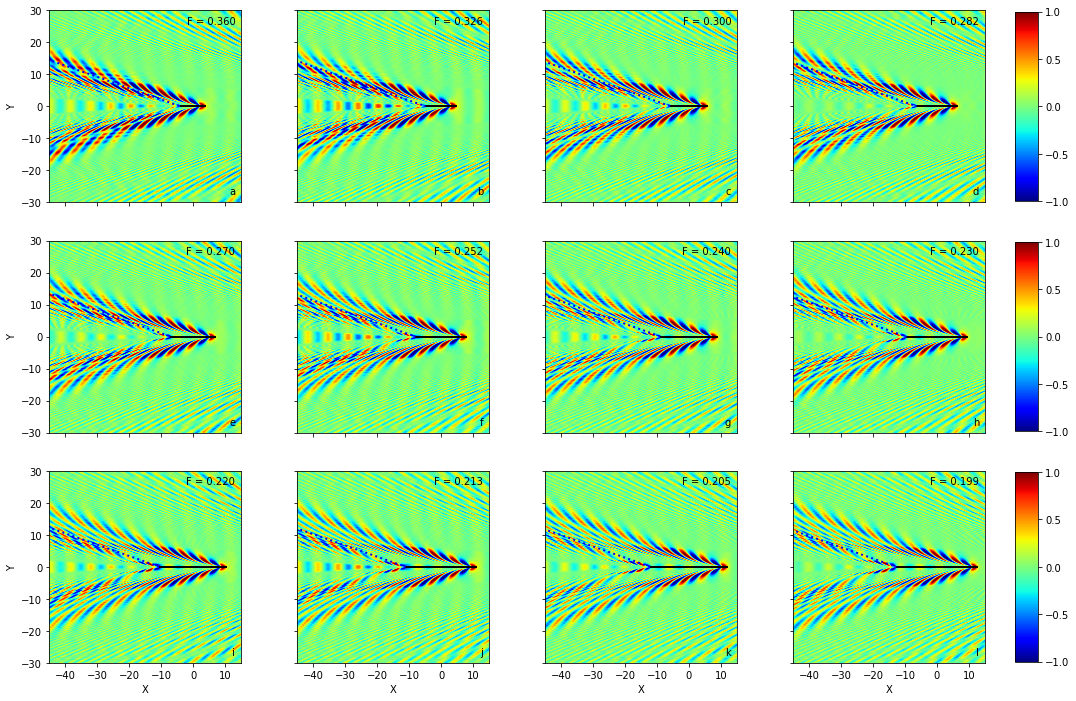

In [15]:
rows = np.array([lowFs[0:4], lowFs[4:8], lowFs[8:12]])
xbounds = [-45, 15]
ybounds = [-30, 30]
bound = 1
scale = True

npy, npx = rows.shape

fig = plt.figure(figsize=(16, 4 * npy))
axs, imgs = [None] * npy, [None] * npy
label = 'a'

for j in range(npy):
    for i in range(npx):
        ind = i + j * npx + 1
        fr = rows[j, i]

        ax1 = fig.add_subplot(npy, npx, ind)
        ax1.set_xlim(xbounds)
        ax1.set_ylim(ybounds)
        ax1.text(0.97, 0.97, r'F = %.3f' % fr, transform=ax1.transAxes, 
                    horizontalalignment='right', 
                    verticalalignment='top')
        lbl = label
        mag = False
        #if j % 2 == 1:
        #    lbl = chr(ord(label) - npx) + '\''
        #    mag = True
        ax1.text(0.97, 0.03, lbl, transform=ax1.transAxes,
                    horizontalalignment='right',
                    verticalalignment='bottom')

        #Plot main image
        img1 = draw_wake_plot(ax1, Xdict[fr], Pdict[fr], 
                              scale=scale, bound=bound, magnitude=mag)

        ax1.set_xlim(xbounds)
        ax1.set_ylim(ybounds)
        
        a = 1. / (fr * fr)
        xm = Xdict[fr][Xdict[fr] < -0.5 * a]
        #ym = Xdict[fr][Xdict[fr] > 0]
        #x, y = np.meshgrid(xm, ym)
        
        plt.plot(np.array([-0.5 * a, 0.5 * a]), np.zeros(2), color='black', linewidth=2)
        draw_kelvin_angle_long(ax1, xm, fr)    
        #phase_contour_diff_color(ax1, x, y, a, fr, phase, extent=[xm[0], xm[-1], ym[0], ym[-1]])
        
        if j == npy-1:
            ax1.set_xlabel('X')
        else:
            nlbls = len(ax1.get_xticklabels())
            ax1.set_xticklabels([''] * nlbls)
        if i == 0:
            ax1.set_ylabel('Y')
        else:
            #Clear tick labels
            nlbls = len(ax1.get_yticklabels())
            ax1.set_yticklabels([''] * nlbls)
        
        axs[j] = ax1
        imgs[j] = img1
        label = chr(ord(label) + 1)

#Add colorbars
fig.subplots_adjust(right=0.95)
ticksmag = [0, 0.5, 1]
ticksreg = [-1, -0.5, 0, 0.5, 1]
for j in range(npy):
    bb = axs[j].get_position().bounds
    cbar_ax = fig.add_axes([0.97, bb[1]+0.00125, 0.02, bb[3]-0.0025])
    fig.colorbar(imgs[j], cax=cbar_ax, 
                 ticks=ticksreg)# if j % 2 == 0 else ticksmag)

plt.show()